In [2]:
!pip install "protobuf<6"

  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


  You can safely remove it manually.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

from bs4 import BeautifulSoup

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [4]:
df_origin = pd.read_csv("df.eneemr")

FileNotFoundError: [Errno 2] No such file or directory: 'df.eneemr'

In [22]:
df_model = df_origin.copy()
random_state = 69
n_components = 0.95

if 'smurf_flag' in df_model.columns:
    y_all = df_model['smurf_flag']
else:
    y_all = None

# Feature Selection
num_df = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['smurf_flag'], errors='ignore')
base_features = [col for col in num_df.columns if col != 'smurf_score']
X = num_df

# Split
X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)
X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]

# Split Labels
if y_all is not None:
    y_train = y_all.loc[X_train_idx]
    y_test = y_all.loc[X_test_idx]
else:
    y_train = y_test = None

# --------------------------------------
# Autoencoder
# --------------------------------------
def AutoEncoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

# StandardScaler & PCA
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train[base_features])
X_test_s = scaler.transform(X_test[base_features])

pca = PCA(n_components=n_components)
X_train_p = pca.fit_transform(X_train_s)
X_test_p = pca.transform(X_test_s)

# Training
autoencoder = AutoEncoder(X_train_p.shape[1])
autoencoder.fit(X_train_p, X_train_p, epochs=30, batch_size=32, validation_split=0.2, shuffle=True, verbose=0)

# Anomaly Scores
train_mse = np.mean(np.square(X_train_p - autoencoder.predict(X_train_p)), axis=1)
test_mse = np.mean(np.square(X_test_p - autoencoder.predict(X_test_p)), axis=1)
threshold = np.percentile(train_mse, 90)
y_train_auto = (train_mse > threshold).astype(int)
y_test_auto = (test_mse > threshold).astype(int)

# --------------------------------------
# Classical Unsupervised Models for Anomaly Detection
# --------------------------------------
models = {
    'IsolationForest': IsolationForest(contamination='auto', random_state=random_state, n_estimators=50),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=15, contamination='auto', novelty=True)
}

results = {
    "AutoEncoder_Train": y_train_auto,
    "AutoEncoder_Test": y_test_auto
}

for name, model in models.items():
    preproc = ColumnTransformer([
        ('pipeline', make_pipeline(StandardScaler(), PCA(n_components=n_components)), base_features)
    ], remainder='passthrough')

    pipe = make_pipeline(preproc, model)
    pipe.fit(X_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    y_train_bin = (y_train_pred == -1).astype(int)
    y_test_bin = (y_test_pred == -1).astype(int)

    results[f"{name}_Train"] = y_train_bin
    results[f"{name}_Test"] = y_test_bin

# --------------------------------------
# Majority Vote
# --------------------------------------
vote_train = (sum([results[k] for k in results if k.endswith("_Train")]) >= 3).astype(int)
vote_test = (sum([results[k] for k in results if k.endswith("_Test")]) >= 3).astype(int)

# DataFrames for Analysis
train_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Train"] for model in ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_train.index)
train_df['MajorityVote'] = vote_train
train_df['Dataset'] = 'Train'

test_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Test"] for model in ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_test.index)
test_df['MajorityVote'] = vote_test
test_df['Dataset'] = 'Test'

comparison_df = pd.concat([train_df, test_df])
if y_train is not None and y_test is not None:
    comparison_df['TrueLabel'] = pd.concat([y_train, y_test])

# --------------------------------------
# Quality-Metrics with Labels
# --------------------------------------
if y_train is not None:
    print("\nMajority Vote (Diagnose mit Labels):")
    print("Train:")
    print(classification_report(y_train, vote_train))
    print("Test:")
    print(classification_report(y_test, vote_test))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Majority Vote (Diagnose mit Labels):
Train:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       771
           1       0.00      0.00      0.00         3

    accuracy                           0.96       774
   macro avg       0.50      0.48      0.49       774
weighted avg       0.99      0.96      0.98       774

Test:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       193
           1       0.00      0.00      0.00         1

    accuracy                           0.95       194
   macro avg       0.50      0.48      0.49       194
weighted avg       0.99      0.95      0.97       194



In [25]:
comparison_df.groupby("Dataset")["MajorityVote"].value_counts()

Dataset  MajorityVote
Test     0               186
         1                 8
Train    0               748
         1                26
Name: count, dtype: int64

In [28]:
df_origin['riot_id'] = df_origin['riotIdGameName'].astype(str) + '#' + df_origin['riotIdTagline'].astype(str) + ' / ' + df_origin['gameId'].astype(str)

df_origin['MajorityVote'] = comparison_df['MajorityVote']
df_origin['MajorityVote']

0      0
1      0
2      0
3      0
4      0
      ..
963    0
964    0
965    0
966    0
967    0
Name: MajorityVote, Length: 968, dtype: int64

In [31]:
df_origin.groupby('MajorityVote')['smurf_category'].value_counts()

MajorityVote  smurf_category
0             normal            929
              likely_smurf        5
1             normal             34
Name: count, dtype: int64

In [34]:
smurf_names = df_origin.loc[df_origin['MajorityVote'] == True, 'riot_id'].unique()
smurf_names

array(['MysTix66#EUW / 7437886591', 'lost ghost 0#EUW / 7438789950',
       'SeñorMónkey#BAGF / 7438789950', 'Lairelossë#1996 / 7438077963',
       'Leopoldina amote#Ducks / 7426489292',
       'brain not found#0dior / 7430652424', 'Walkeyy#EUW / 7381750636',
       'TARICISPANSEXUAL#004 / 7381750636', 'Horizon#3521 / 7435202713',
       'YAKUZA#NORTH / 7318428854', 'NinyaK#Ninya / 7352340198',
       'Buckac#101 / 7388903110', 'leagueoflegends#6538 / 7438352716',
       'CaRiiaTV#EUW / 7287427635', 'InvocateurOf94#EUW / 7287427635',
       'CPG Nono#0012 / 7287427635', 'selfrightousness#EUW2 / 7438707305',
       'PigeonCrack#5016 / 7438665053', 'Moist#EUW55 / 7438687688',
       'DrainspeII#EUW / 7433289996', 'Nijura#3135 / 7428670435',
       '3lv3r g4l4rg4 ti#salud / 7437505266', 'Fedo74#EUW / 7282454429',
       'Que Rico Ñam#EUGEO / 7419621690',
       'TwinkGaming217#viego / 7413129200', 'GudLxck#help / 7434653251',
       'جنغلر يطبخ بطاطس#Yeet / 7434653251',
       'HaramSpide

In [3]:
'''#Detection-Model with Labeled Data

df_model = df_origin

n_components = 0.95
random_state = 69

# smurf_score separat behandeln
# smurf_flag is basically y_test
num_df = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['smurf_flag'])
all_feautures = num_df.columns.tolist()
base_features = [col for col in all_feautures if col != 'smurf_score']
X = num_df
y = df_model['smurf_flag']

# Train-Test-Split
X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(X.index, y.index, test_size=0.2, random_state=random_state)
X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]
y_train = y.loc[y_train_idx]
y_test = y.loc[y_test_idx]

# AutoEncoder Definition
def AutoEncoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

# AutoEncoder Training
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train[base_features])
X_test_s = scaler.transform(X_test[base_features])

pca_s = PCA(n_components=n_components)
X_train_p = pca_s.fit_transform(X_train_s)
X_test_p = pca_s.transform(X_test_s)

autoencoder = AutoEncoder(X_train_p.shape[1])
autoencoder.fit(X_train_p, X_train_p, epochs=30, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

train_pred = autoencoder.predict(X_train_p)
test_pred = autoencoder.predict(X_test_p)
train_mse = np.mean(np.square(X_train_p - train_pred), axis=1)
test_mse = np.mean(np.square(X_test_p - test_pred), axis=1)
threshold = np.percentile(train_mse, 95)

y_train_autoencoder = (train_mse > threshold).astype(int)
y_test_autoencoder = (test_mse > threshold).astype(int)


# Klassische Modelle
models = {
    'IsolationForest': IsolationForest(contamination='auto', random_state=random_state),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
}

results = {
    "AutoEncoder_Train": y_train_autoencoder,
    "AutoEncoder_Test": y_test_autoencoder
}

# Evaluation für AutoEncoder
print("\nAutoEncoder:")
print("Train:")
print(classification_report(y_train, y_train_autoencoder))
print("Test:")
print(classification_report(y_test, y_test_autoencoder))

for name, model in models.items():
    print(f"\n{name}:")

    # Pipeline inkl. Preprocessing
    preprocessor = ColumnTransformer([
        ('pca_pipeline', make_pipeline(StandardScaler(), PCA(n_components=n_components)), base_features)
    ], remainder='passthrough')

    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train)

    # Prediction
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Convert to binary anomaly labels (1=Anomalie)
    y_train_bin = (y_train_pred == -1).astype(int)
    y_test_bin = (y_test_pred == -1).astype(int)

    # Speichern für Majority Vote
    results[f"{name}_Train"] = y_train_bin
    results[f"{name}_Test"] = y_test_bin

    # Bewertung mit echten Labels
    print("Train:")
    print(classification_report(y_train, y_train_bin))
    print("Test:")
    print(classification_report(y_test, y_test_bin))

# Majority Vote
vote_train = sum([results[k] for k in results if k.endswith("_Train")]) >= 3
vote_test = sum([results[k] for k in results if k.endswith("_Test")]) >= 3

# Zusammenfassen
train_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Train"] for model in ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_train.index)
train_df['MajorityVote'] = vote_train.astype(int)
train_df['Dataset'] = 'Train'

test_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Test"] for model in ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_test.index)
test_df['MajorityVote'] = vote_test.astype(int)
test_df['Dataset'] = 'Test'

comparison_df = pd.concat([train_df, test_df]).reset_index(drop=True)
comparison_df['TrueLabel'] = pd.concat([y_train, y_test]).reset_index(drop=True)

# Bewertung des Majority Vote
print("\nMajority Vote:")
print("Train:")
print(classification_report(y_train, train_df['MajorityVote']))
print("Test:")
print(classification_report(y_test, test_df['MajorityVote']))'''


2025-06-30 16:11:26.926092: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

AutoEncoder:
Train:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       771
           1       0.03      0.33      0.05         3

    accuracy                           0.95       774
   macro avg       0.51      0.64      0.51       774
weighted avg       0.99      0.95      0.97       774

Test:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       193
           1       0.00      0.00      0.00         1

    accuracy                           0.94       194
   macro avg       0.50      0.47      0.48       194
weighted avg       0.99      0.94      0.96       194


IsolationForest:
Train:
              precision    recall

['Diffdoff2#EUW / 7437397109', 'SeñorMónkey#BAGF / 7438789950',
       'Dellel#EUW / 7437576834', 'meeksooon#win / 7430652424',
       'banana#coco / 7364655002', 'toiletchair951#EUW2 / 7352340198',
       'Engelsblut#KICK / 7432679847', 'Hyacine#E6S5 / 7432679847',
       'Sabstitch Slave#D3DOZ / 7426336630',
       'ItsCalledSoccer#USA1 / 7437654394', 'AfroGamer#EUW / 7429255573',
       'MRW#2222 / 7434332831', 'bmgShade#EUW / 7413699383',
       'Rouladen Rolf#EUW / 7416703754', 'Drmleth#EUW / 7435446611',
       'schizoephrenia#ktmn / 7438250342', 'javift5#EUW / 7435636691',
       'Maskrosen#SID / 7433289996', 'IsaBeck#EUW / 7437505266',
       'Skipiox05#EUW / 7438215512', 'TheHumanSpider#1337 / 7434429026',
       'TitoFuentes#EUW / 7438430547', 'modzarela#EUW / 7434653251',
       'Jonas Bronzraff#EUW / 7402292271', 'MissKXopo#9696 / 7318189100',
       'Unforgiven Blade#YASUO / 7438557339',
       'Erlolo1979#EEB / 7438557339', 'Sytzha#8077 / 7428295159',
       'Triggi#OMEN / 7436458146', 'Mente Fría#T44 / 7433136017',
       'IronmanX36Rebel#EUW / 7314216878', 'sorry#QYB0 / 7352598438',
       'TheHalfShadow#EUW / 7352598438', 'KaynAtm#EUW / 7437527699']

In [8]:
test = df_origin[df_origin['riotIdGameName'] == "Diffdoff2"]
test["smurf_flag"]

1    0
Name: smurf_flag, dtype: int64

In [30]:
test2 = df_origin[df_origin['smurf_flag']==1]
test2['riot_id']

571        Cursed Blade#EU1 / 7398388803
572              kitten#glo / 7398388803
698      SheIsntWorthIt#QwQ / 7419621690
741    SungJinwøøLvL100#SJW / 7425664201
Name: riot_id, dtype: object

In [142]:
'''with open("smurf_stats.json", "w", encoding="utf-8") as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)'''

In [145]:
'''#Labeling of realsmurfs 

with open("smurf_stats.json", "r", encoding="utf-8") as f:
    data = json.load(f)

for entry in data:
    print(f"\nSummoner: {entry['summoner']}, Match: {entry['match_id']}")
    print(f"KDA: {entry['kills']}/{entry['deaths']}/{entry['assists']}")
    print(f"Rank: {entry['rank']} | CS/min: {entry['cs_per_min']} | Gold/min: {entry['gold_per_min']}")
    print(f"Kill Participation: {entry['kill_participation']} | Vision Score: {entry['vision_score']}")

    label = input("Smurf? (y/n): ").strip().lower()
    entry['label'] = 1 if label == 'y' else 0'''


Summoner: meeksooon#win, Match: 7430652424
KDA: 5/9/4
Rank: Emerald IV | CS/min: 6.1 | Gold/min: 407.4
Kill Participation: 47% Kill participation | Vision Score: 6

Summoner: banana#coco, Match: 7364655002
KDA: 2/4/0
Rank: Emerald III | CS/min: 4.7 | Gold/min: 300.6
Kill Participation: 50% Kill participation | Vision Score: 10

Summoner: toiletchair951#EUW2, Match: 7352340198
KDA: 1/12/3
Rank: Emerald I | CS/min: 6.5 | Gold/min: 316.6
Kill Participation: 11% Kill participation | Vision Score: 22


KeyboardInterrupt: Interrupted by user

In [ ]:
# Nächste Schritte: Dataframe mehr Daten reinkriegen, 
# In smurf_stats.json sind nur ranked solo/duo games drinne (konnte nicht im df gefiltert werden)
# Beim scraper noch championnamen adden

In [94]:
#Evaluation

from sklearn.metrics import classification_report

print(classification_report(df_origin['smurf_flag'], df_origin['MajorityVote']))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       964
           1       0.00      0.00      0.00         4

    accuracy                           0.93       968
   macro avg       0.50      0.47      0.48       968
weighted avg       0.99      0.93      0.96       968



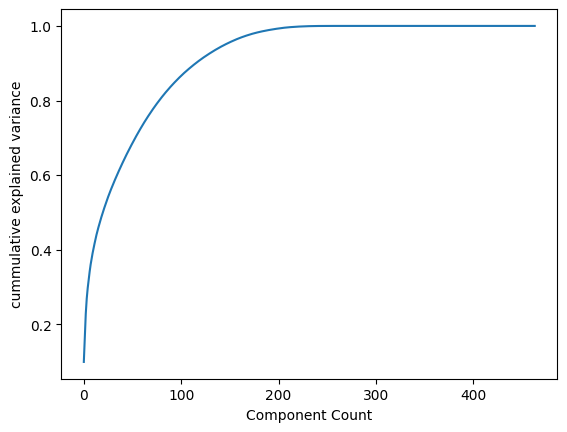

In [11]:
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)
pca = PCA().fit(Xs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Count')
plt.ylabel('cummulative explained variance')
plt.show()

In [9]:
'''all_results = []

def scrape_match_info(match_id, target_name, region='euw'):
    url = f"https://www.leagueofgraphs.com/match/{region}/{match_id}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return None

    soup = BeautifulSoup(response.text, 'html.parser')
    players = soup.select('tr.playerRow')
    target_riot_id = target_name.strip().lower()

    queue_span = soup.select_one('th span.queueName')
    queue_name = queue_span.text.strip() if queue_span else 'Unknown'

    for player in players:
        left_td = player.select_one('td.text-left.summoner_column')
        right_td = player.select_one('td.text-right.summoner_column')
        kda_columns = player.select('td.kdaColumn')
        kda_divs = player.select('div.kda')

        for i, td in enumerate([left_td, right_td]):
            if td is None:
                continue

            name_div = td.select_one('div.name')
            if not name_div:
                continue

            full_name = name_div.text.strip()
            full_name_clean = full_name.replace(" ", "").lower()
            target_clean = target_riot_id.replace(" ", "").lower()

            if full_name_clean != target_clean:
                continue

            # KDA
            kda_div = kda_divs[i] if len(kda_divs) > i else None
            kills = kda_div.select_one('span.kills').text if kda_div else '?'
            deaths = kda_div.select_one('span.deaths').text if kda_div else '?'
            assists = kda_div.select_one('span.assists').text if kda_div else '?'

            # Rank
            subname_div = td.select_one('div.subname')
            rank = subname_div.text.strip() if subname_div else 'unranked'

            # Level
            level_divs = player.select('div.level')
            level = level_divs[i].text.strip() if len(level_divs) > i else '?'

            # Tooltip-Stats
            tooltip_td = kda_columns[i] if len(kda_columns) > i else None
            tooltip_html = tooltip_td.get('tooltip', '') if tooltip_td else ''
            tooltip_soup = BeautifulSoup(tooltip_html, 'html.parser')

            def extract_stat(label):
                text = tooltip_soup.find(string=lambda t: label in t)
                return text.split(":")[-1].strip() if text else '?'

            minions = extract_stat("Minions")
            cs_per_min = extract_stat("CS / min")
            gold_per_min = extract_stat("Gold / min")
            kill_participation = extract_stat("Kill participation")
            vision_score = extract_stat("Vision Score")
            vision_per_min = extract_stat("Vision Score / minute")

            return {
                'summoner': full_name.strip(),
                'match_id': match_id,
                'queue': queue_name,
                'kills': int(kills),
                'deaths': int(deaths),
                'assists': int(assists),
                'rank': rank,
                'level': int(level) if level.isdigit() else '?',
                'minions': int(minions),
                'cs_per_min': float(cs_per_min),
                'gold_per_min': float(gold_per_min),
                'kill_participation': kill_participation,
                'vision_score': int(vision_score),
                'vision_per_min': float(vision_per_min)
            }

    return None

for riot_id in smurf_names:
    try:
        name_part, match_id = riot_id.split(" / ")
        name_part = name_part.strip()
        match_id = match_id.strip()

        result = scrape_match_info(match_id, name_part)

        if result and 'solo' in result['queue'].lower():
            all_results.append(result)

    except Exception as e:
        print(f"Fehler bei {riot_id}: {e}")'''

KeyboardInterrupt: 

In [5]:
'''
n_components = 0.95
random_state = 69

# Daten vorbereiten
num_df = df_main.select_dtypes(include=['float64', 'int64'])
num_df = num_df.drop(columns=['smurf_flag'])  # smurf_flag is basically y_test

# smurf_score separat behandeln
base_features = [col for col in num_df.columns.tolist() if col != 'smurf_score']
X = num_df

X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)
X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]

# Modell-Container
models = {
    'IsolationForest': IsolationForest(contamination='auto', random_state=random_state),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
}

results = {}

# Modelle durchlaufen
for name, model in models.items():
    # Preprocessing-Pipeline: PCA auf alle außer smurf_score
    preprocessor = ColumnTransformer([
        ('pca_pipeline', make_pipeline(StandardScaler(), PCA(n_components=n_components)), base_features)
    ], remainder='passthrough')  # smurf_score bleibt erhalten

    pipe = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])

    # Train & Predict
    pipe.fit(X_train)
    y_train = pipe.predict(X_train)
    y_test = pipe.predict(X_test)

    results[f"{name}_Train"] = (y_train == -1).astype(int)
    results[f"{name}_Test"] = (y_test == -1).astype(int)

# Majority Vote
vote_train = (results["IsolationForest_Train"] + results["OneClassSVM_Train"] + results["LocalOutlierFactor_Train"]) >= 2
vote_test = (results["IsolationForest_Test"] + results["OneClassSVM_Test"] + results["LocalOutlierFactor_Test"]) >= 2

# Ergebnis-DataFrames
train_df = pd.DataFrame({
    "IF": results["IsolationForest_Train"],
    "SVM": results["OneClassSVM_Train"],
    "LOF": results["LocalOutlierFactor_Train"],
    "MajorityVote": vote_train.astype(int),
    "Dataset": "Train"
}, index=X_train.index)

test_df = pd.DataFrame({
    "IF": results["IsolationForest_Test"],
    "SVM": results["OneClassSVM_Test"],
    "LOF": results["LocalOutlierFactor_Test"],
    "MajorityVote": vote_test.astype(int),
    "Dataset": "Test"
}, index=X_test.index)

# Vergleich & Auswertung
comparison_df = pd.concat([train_df, test_df]).reset_index(drop=True)
majority_vote_summary = comparison_df.groupby("Dataset")["MajorityVote"].sum().to_frame(name="Sum_MajorityVotes")

train_size = comparison_df[comparison_df["Dataset"] == "Train"].shape[0]
test_size = comparison_df[comparison_df["Dataset"] == "Test"].shape[0]

train_ratio = majority_vote_summary.loc["Train", "Sum_MajorityVotes"] / train_size
test_ratio = majority_vote_summary.loc["Test", "Sum_MajorityVotes"] / test_size

print("Anteil Ausreißer im Training:", round(train_ratio, 8))
print("Anteil Ausreißer im Test:    ", round(test_ratio, 8))
'''

NameError: name 'ColumnTransformer' is not defined

In [6]:
'''
n_components=0.95
random_state = 69

num_df = df_main.select_dtypes(include=['float64','int64'])
num_df = num_df.drop(columns=['smurf_flag'])
X = num_df

X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)

X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]

def AutoEncoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)

    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(Adam(learning_rate=0.001), loss='mse')
    return autoencoder

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

pca_s = PCA(n_components=n_components)
X_train_p = pca_s.fit_transform(X_train_s)
X_test_p = pca_s.transform(X_test_s)

autoencoder = AutoEncoder(X_train_p.shape[1])
autoencoder.fit(X_train_p, X_train_p, epochs=30, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

train_reconstruction_loss = autoencoder.predict(X_train_p)
test_reconstruction_loss = autoencoder.predict(X_test_p)

train_mse = np.mean(np.square(X_train_p - train_reconstruction_loss), axis=1)
test_mse = np.mean(np.square(X_test_p - test_reconstruction_loss), axis=1)

threshold = np.percentile(train_mse, 95)

y_train_autoencoder = (train_mse > threshold).astype(int)
y_test_autoencoder = (test_mse > threshold).astype(int)


models = {
    'IsolationForest': IsolationForest(contamination='auto', random_state=random_state),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
}

results = {
    "AutoEncoder_Train": y_train_autoencoder,
    "AutoEncoder_Test": y_test_autoencoder
}

for name, model in models.items():
    pipe = make_pipeline(
        StandardScaler(),
        PCA(n_components),
        model
    )

    pipe.fit(X_train)
    y_train = pipe.predict(X_train)
    y_test = pipe.predict(X_test)

    results[f"{name}_Train"] = (y_train == -1).astype(int)
    results[f"{name}_Test"] = (y_test == -1).astype(int)

vote_train = (
    results["IsolationForest_Train"] +
    results["OneClassSVM_Train"] +
    results["LocalOutlierFactor_Train"] +
    results["AutoEncoder_Train"]
    ) >= 2
vote_test = (
    results["IsolationForest_Test"] +
    results["OneClassSVM_Test"] +
    results["LocalOutlierFactor_Test"] +
    results["AutoEncoder_Test"]
    ) >= 2

train_df = pd.DataFrame({
    "IF": results["IsolationForest_Train"],
    "SVM": results["OneClassSVM_Train"],
    "LOF": results["LocalOutlierFactor_Train"],
    "AE": results["AutoEncoder_Train"],
    "MajorityVote": vote_train.astype(int),
    "Dataset": "Train"
}, index=X_train.index)

test_df = pd.DataFrame({
    "IF": results["IsolationForest_Test"],
    "SVM": results["OneClassSVM_Test"],
    "LOF": results["LocalOutlierFactor_Test"],
    "AE": results["AutoEncoder_Test"],
    "MajorityVote": vote_test.astype(int),
    "Dataset": "Test"
}, index=X_test.index)

comparison_df = pd.concat([train_df, test_df]).reset_index(drop=True)

majority_vote_summary = comparison_df.groupby("Dataset")["MajorityVote"].sum().to_frame(name="Sum_MajorityVotes")

train_size = comparison_df[comparison_df["Dataset"] == "Train"].shape[0]
test_size = comparison_df[comparison_df["Dataset"] == "Test"].shape[0]

train_ratio = majority_vote_summary.loc["Train", "Sum_MajorityVotes"] / train_size
test_ratio = majority_vote_summary.loc["Test", "Sum_MajorityVotes"] / test_size

print("Anteil Ausreißer im Training:", round(train_ratio, 8))
print("Anteil Ausreißer im Test:    ", round(test_ratio, 8))
'''

SyntaxError: incomplete input (3583353656.py, line 6)

In [4]:
'''n_components=0.95

num_df = df_main.select_dtypes(include=['float64','int64'])
X = num_df

X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=42)

X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]


pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components),
    IsolationForest(contamination='auto', random_state=20)
)

pipe.fit(X_train)
y_train = pipe.predict(X_train)
y_test = pipe.predict(X_test)

df_main.loc[X_train.index, 'isSmurfTrain'] = (y_train == -1).astype(int)
df_main.loc[X_test.index, 'isSmurfTest'] = (y_test == -1).astype(int)

print("Anteil Ausreißer im Training:",  (y_train==-1).mean())
print("Anteil Ausreißer im Test:    ",  (y_test ==-1).mean())
'''

'n_components=0.95\n\nnum_df = df_main.select_dtypes(include=[\'float64\',\'int64\'])\nX = num_df\n\nX_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=42)\n\nX_train = X.loc[X_train_idx]\nX_test = X.loc[X_test_idx]\n\n\npipe = make_pipeline(\n    StandardScaler(),\n    PCA(n_components),\n    IsolationForest(contamination=\'auto\', random_state=20)\n)\n\npipe.fit(X_train)\ny_train = pipe.predict(X_train)\ny_test = pipe.predict(X_test)\n\ndf_main.loc[X_train.index, \'isSmurfTrain\'] = (y_train == -1).astype(int)\ndf_main.loc[X_test.index, \'isSmurfTest\'] = (y_test == -1).astype(int)\n\nprint("Anteil Ausreißer im Training:",  (y_train==-1).mean())\nprint("Anteil Ausreißer im Test:    ",  (y_test ==-1).mean())'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5ba84711-b236-4487-8349-fb1f4283f4bd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>